In [16]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements’ keys.

In [1]:
import os
import math
import json
import random
import numpy as np
from functools import partial

In [8]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  


In [14]:
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [15]:
# Two pre-trained models are downloaded below. Make sure to have adjusted your CHECKPOINT_PATH before running this code if not already done.

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


##### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries 
, keys 
 and values 
 where  is the sequence length, and 
 and 
 are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element  to  is based on its similarity of the query 
 and key 
, using the dot product as the similarity metric

In [17]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [18]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


#####  Multi-Head Attention


The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into  sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix.

In [19]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

##### Transformer Encoder

In [20]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [21]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

##### Positional encoding

In [22]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


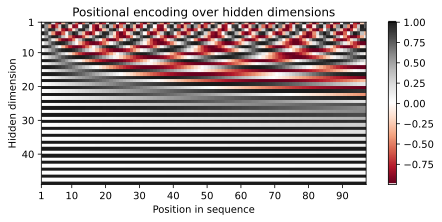

In [23]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()


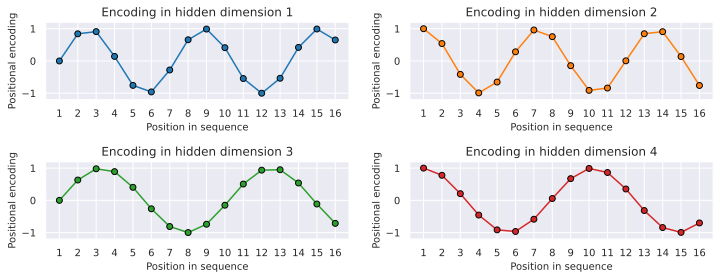

In [24]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

##### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing.

Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like RAdam have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using Pre-Layer Normalization (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques (Adaptive Normalization, Power Normalization).

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs.

In [26]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

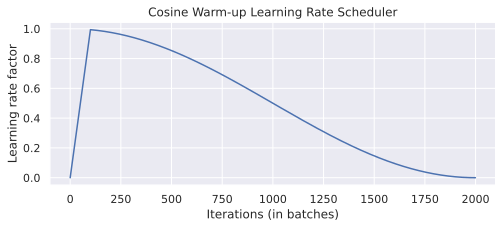

In [27]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

##### PyTorch Lightning Module

In [28]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

#### Experiments

##### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input and the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of  numbers between  and , the task is to reverse the input sequence. In Numpy notation, if our input is , the output should be [::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well.

In [29]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [30]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [31]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


In [33]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [34]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=10,
                         gradient_clip_val=5,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [35]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:903: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprec

Found pretrained model, loading...


Missing logger folder: ../saved_models/tutorial6/ReverseTask/lightning_logs
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

In [36]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [37]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

The object attention_maps is a list of length  where  is the number of layers. Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.



In [38]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [39]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()


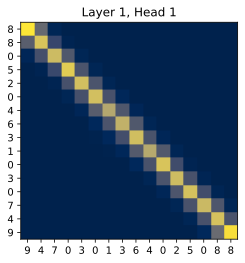

In [40]:
plot_attention_maps(data_input, attention_maps, idx=0)

##### Set Anomaly Detection

In [42]:
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)
# Files already downloaded and verified
# Files already downloaded and verified

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified


In [43]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial6/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [45]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

  0%|          | 0/391 [00:00<?, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

In [ ]:
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [ ]:
class SetAnomalyDataset(data.Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train

        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()


    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets


    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices


    def __len__(self):
        return self.img_feats.shape[0]


    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1

        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label


In [ ]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=4)


In [ ]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

In [ ]:
class AnomalyPredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False) # No positional encodings as it is a set, not a sequence!
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [ ]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=100,
                         gradient_clip_val=2,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=train_anom_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

In [ ]:
nomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

In [ ]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

With ~94% validation and test accuracy, the model generalizes quite well. It should be noted that you might see slightly different scores depending on what computer/device you are running this notebook. This is because despite setting the seed before generating the test dataset, it is not the same across platforms and numpy versions. Nevertheless, we can conclude that the model performs quite well and can solve the task for most sets. Before trying to interpret the model, let’s verify that our model is permutation-equivariant, and assigns the same predictions for different permutations of the input set. For this, we sample a batch from the test set and run it through the model to obtain the probabilities.


In [ ]:

inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

To interpret the model a little more, we can plot the attention maps inside the model. This will give us an idea of what information the model is sharing/communicating between images, and what each head might represent. First, we need to extract the attention maps for the test batch above, and determine the discrete predictions for simplicity.



In [ ]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

In [ ]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

In [ ]:
visualize_prediction(0)

In [ ]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

In [ ]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print(f"Image {i}: {100.0*p:4.2f}%")